<a href="https://colab.research.google.com/github/kapamawi/AI/blob/main/2_8_1___obrazki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install -q "autogen-agentchat[lmm]~=0.2"

Ten kawałek kodu to polecenie instalacyjne używane w środowisku Python. Instaluje ono bibliotekę "autogen-agentchat" w wersji około 0.2 wraz z dodatkowymi funkcjonalnościami oznaczonymi jako "lmm".

Flaga -q (quiet) sprawia, że instalacja przebiega w trybie cichym - pokazywane są tylko najważniejsze komunikaty, bez szczegółowych informacji o procesie instalacji.

Znak tyldy (~=) przed numerem wersji oznacza, że zostanie zainstalowana wersja kompatybilna z 0.2, ale może to być dowolna wersja z serii 0.2.x. Na przykład może zostać zainstalowana wersja 0.2.1 lub 0.2.5, ale nie 0.3.0.

Biblioteka autogen-agentchat służy do tworzenia i zarządzania konwersacjami między agentami AI. Tag [lmm] wskazuje na instalację dodatkowego modułu związanego z modelami językowymi.

In [ ]:
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.24.0 requires anyio<4,>=3.1.0, but you have anyio 4.7.0 which is incompatible.


To polecenie instalacyjne w środowisku Python wykonuje trzy główne operacje:

1. Instaluje bibliotekę OpenAI dokładnie w wersji 1.55.3
2. Instaluje bibliotekę httpx dokładnie w wersji 0.27.2
3. Używa flag:
   - --force-reinstall: wymusza ponowną instalację tych pakietów, nawet jeśli są już zainstalowane
   - --quiet: redukuje ilość wyświetlanych komunikatów podczas instalacji do minimum

Biblioteka OpenAI to oficjalne narzędzie do komunikacji z API OpenAI, natomiast httpx to nowoczesna biblioteka HTTP dla Pythona, która obsługuje asynchroniczne żądania.

In [ ]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored
from google.colab import userdata

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Ten kod importuje szereg bibliotek i modułów Pythona potrzebnych do pracy z różnymi funkcjonalnościami:

Standardowe biblioteki Pythona:
- json: do obsługi formatu JSON
- os: do operacji systemowych
- pdb: debugger Pythona
- random: generator liczb losowych
- re: obsługa wyrażeń regularnych
- time: funkcje związane z czasem
- typing: definicje typów

Biblioteki zewnętrzne:
- matplotlib.pyplot: tworzenie wykresów
- PIL (Python Imaging Library): przetwarzanie obrazów
- requests: obsługa zapytań HTTP
- diskcache: system pamięci podręcznej na dysku
- openai: interfejs do API OpenAI
- termcolor: kolorowy tekst w terminalu
- google.colab.userdata: dostęp do danych użytkownika w Google Colab

Moduły autogen:
- podstawowe klasy agentów (Agent, AssistantAgent, ConversableAgent, UserProxyAgent)
- narzędzia do obsługi obrazów (get_image_data, get_pil_image, gpt4v_formatter)
- klasa MultimodalConversableAgent do obsługi różnych typów mediów

In [ ]:
# configs
openai_api = userdata.get('openaivision')


In [ ]:

config_list_4v =   [ { 'model': "gpt-4-turbo", 'api_key': openai_api} ]

config_list_dalle =   [ { 'model': 'dalle', 'api_key': openai_api} ]

config_list_gpt4 =   [ { 'model': "gpt-4o-mini", 'api_key': openai_api} ]

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}


Te linie kodu definiują trzy różne konfiguracje dla modeli językowych i jeden słownik konfiguracyjny:

1. config_list_4v:
   - Lista zawierająca słownik z konfiguracją dla modelu gpt-4-turbo
   - Używa klucza API zapisanego w zmiennej openai_api

2. config_list_dalle:
   - Lista zawierająca słownik z konfiguracją dla modelu DALL-E
   - Korzysta z tego samego klucza API

3. config_list_gpt4:
   - Lista zawierająca słownik z konfiguracją dla modelu gpt-4o-mini
   - Również używa tego samego klucza API

4. gpt4_llm_config:
   - Słownik zawierający dwa parametry:
   - config_list: używa wcześniej zdefiniowanej konfiguracji config_list_gpt4
   - cache_seed: ustawia ziarno losowości na 42, co zapewnia powtarzalność wyników przy korzystaniu z pamięci podręcznej

# Functions

In [ ]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:


    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

Ta funkcja służy do generowania obrazów za pomocą DALL-E i zarządzania ich pamięcią podręczną. Przyjmuje następujące parametry:

- client: instancja klienta OpenAI
- model: nazwa modelu DALL-E
- prompt: tekstowy opis obrazu do wygenerowania
- size: rozmiar obrazu
- quality: jakość obrazu
- n: liczba obrazów do wygenerowania

Funkcja działa w następujących krokach:

1. Tworzy folder .cache/ do przechowywania wygenerowanych obrazów
2. Tworzy klucz na podstawie parametrów wejściowych
3. Sprawdza czy obraz o takich parametrach już istnieje w pamięci podręcznej
4. Jeśli istnieje - zwraca zapisany obraz
5. Jeśli nie istnieje:
   - Generuje nowy obraz przez API OpenAI
   - Pobiera URL wygenerowanego obrazu
   - Pobiera dane obrazu z URL
   - Zapisuje obraz w pamięci podręcznej
   - Zwraca dane obrazu

Użycie pamięci podręcznej pozwala uniknąć ponownego generowania tych samych obrazów i przyspiesza działanie programu.

In [ ]:
def extract_img(agent: Agent) -> PIL.Image:

    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

Ta funkcja służy do wydobywania obrazów z wiadomości agenta. Ma następującą logikę:

1. Pobiera ostatnią wiadomość od agenta
2. Obsługuje dwa formaty wiadomości:

   - Tekst (str):
     - Szuka znacznika <img> w tekście
     - Wyodrębnia dane obrazu z tego znacznika

   - Lista (list):
     - Zakłada że jest to format GPT-4V
     - Sprawdza czy pierwszy element to słownik
     - Pobiera URL obrazu ze ścieżki image_url.url

3. Konwertuje dane obrazu na obiekt PIL.Image
4. Zwraca obraz w formacie PIL

Funkcja używa wyrażeń regularnych do wyszukiwania znaczników HTML i biblioteki PIL do przetwarzania obrazów.

In [ ]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]

        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

Ta klasa tworzy agenta specjalizującego się w generowaniu obrazów przez DALL-E. Dziedziczy po ConversableAgent i zawiera następujące elementy:

Konstruktor __init__:
- Przyjmuje nazwę agenta i konfigurację modelu językowego
- Próbuje pobrać klucz API z konfiguracji
- Jeśli się nie uda, szuka klucza w zmiennych środowiskowych
- Tworzy klienta DALL-E
- Rejestruje metodę generate_dalle_reply jako odpowiedź na wiadomości

Metoda send:
- Nadpisuje standardową metodę wysyłania wiadomości
- Wymusza tryb cichy (silent=True) aby uniknąć długich logów

Metoda generate_dalle_reply:
- Główna metoda generująca odpowiedzi w formie obrazów
- Używa klienta DALL-E lub dostarczonej konfiguracji
- Pobiera treść ostatniej wiadomości jako prompt
- Wywołuje DALL-E z ustalonymi parametrami:
  - model: dall-e-3
  - rozmiar: 1024x1024
  - jakość: standardowa
  - liczba obrazów: 1
- Konwertuje wynik na format obrazu PIL
- Zwraca obraz w formacie zgodnym z OpenAI

# Test

In [ ]:
dalle = DALLEAgent(name="Dalle", llm_config={"config_list": config_list_dalle})

user_proxy = UserProxyAgent(
    name="User_proxy", system_message="A human admin.", human_input_mode="NEVER", max_consecutive_auto_reply=0
)

# Ask the question with an image
user_proxy.initiate_chat(
    dalle,
    message="""Create an image with black background, a happy robot is showing a sign with "I Love AutoGen".""",
)

User_proxy (to Dalle):

Create an image with black background, a happy robot is showing a sign with "I Love AutoGen".

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with black background, a happy robot is showing a sign with "I Love AutoGen".', 'role': 'assistant', 'name': 'User_proxy'}, {'content': [{'type': 'image_url', 'image_url': {'url': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x7CEFB86BDFF0>}}], 'role': 'user', 'name': 'Dalle'}], summary='', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

Ta część kodu tworzy i uruchamia interakcję między dwoma agentami:

1. Tworzy instancję DALLEAgent o nazwie "Dalle":
   - Używa wcześniej zdefiniowanej konfiguracji config_list_dalle
   - Agent będzie odpowiedzialny za generowanie obrazów

2. Tworzy instancję UserProxyAgent o nazwie "User_proxy":
   - System_message ustawia go jako "administratora-człowieka"
   - Human_input_mode="NEVER" oznacza, że agent działa automatycznie bez interwencji człowieka
   - max_consecutive_auto_reply=0 ogranicza liczbę automatycznych odpowiedzi do zera

3. Rozpoczyna rozmowę między agentami:
   - User_proxy inicjuje czat z agentem DALL-E
   - Wysyła prośbę o stworzenie obrazu z konkretnym opisem:
     - czarne tło
     - szczęśliwy robot
     - trzymający znak z napisem "I Love AutoGen"

DALL-E użyje tego opisu do wygenerowania odpowiedniego obrazu.

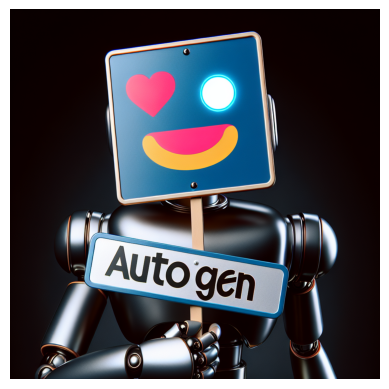

In [ ]:
img = extract_img(dalle)

plt.imshow(img)
plt.axis("off")
plt.show()

Te linie kodu służą do wyświetlenia wygenerowanego obrazu:

1. img = extract_img(dalle)
   - Pobiera wygenerowany obraz z ostatniej wiadomości agenta DALL-E
   - Konwertuje go na format umożliwiający wyświetlenie

2. Komenda plt.imshow(img)
   - Przygotowuje obraz do wyświetlenia za pomocą biblioteki matplotlib

3. plt.axis("off")
   - Wyłącza wyświetlanie osi na wykresie
   - Dzięki temu widoczny będzie sam obraz bez dodatkowych elementów

4. plt.show()
   - Wyświetla przygotowany obraz

# Krytyka niepolityczna

In [ ]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        ## Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)
        plt.imshow(img)
        plt.axis("off")  # Turn off axis numbers
        plt.show()
        print("Image PLOTTED")

        for i in range(self._n_iters):
            # Downsample the image s.t. GPT-4V can take
            img = extract_img(self.dalle)
            smaller_image = img.resize((128, 128), Image.Resampling.LANCZOS)
            smaller_image.save("result.png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            img_prompt = re.findall("PROMPT: (.*)", feedback)[0]

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            plt.imshow(img)
            plt.axis("off")  # Turn off axis numbers
            plt.show()
            print(f"Image {i} PLOTTED")

        return True, "result.jpg"

Ta klasa DalleCreator to wyspecjalizowany agent służący do iteracyjnego ulepszania obrazów. Składa się z następujących elementów:

Konstruktor inicjalizuje:
- n_iters: liczba iteracji ulepszania obrazu (domyślnie 2)
- Rejestruje metodę _reply_user jako główną funkcję odpowiedzi

Metoda _reply_user zawiera główną logikę:

1. Sprawdza poprawność parametrów wejściowych (messages i sender)

2. Tworzy dwóch podagentów:
   - Critics: agent analizujący obrazy i sugerujący ulepszenia
   - Dalle: agent generujący obrazy

3. Proces iteracyjnego ulepszania:
   - Generuje pierwszy obraz na podstawie promptu
   - Wyświetla go
   - Rozpoczyna pętlę ulepszeń:
     - Zmniejsza obraz do 128x128 dla GPT-4V
     - Zapisuje pomniejszony obraz
     - Prosi Critics o analizę i sugestie ulepszeń
     - Wyodrębnia nowy prompt z odpowiedzi Critics
     - Generuje nowy obraz używając ulepszonego promptu
     - Wyświetla wynik
   - Powtarza proces określoną liczbę razy

4. Zwraca nazwę pliku z końcowym wynikiem

Critics otrzymuje specjalny format odpowiedzi:
- CRITICS: opis co należy poprawić
- PROMPT: ulepszony prompt dla DALL-E

In [ ]:
creator = DalleCreator(
    name="DALLECreator",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)


Te linie tworzą dwa agenty do automatycznego generowania i ulepszania obrazów:

1. DalleCreator o nazwie "DALLECreator":
   - max_consecutive_auto_reply=0: wyłącza automatyczne odpowiedzi
   - system_message określa jego rolę jako koordynatora generowania obrazów
   - używa konfiguracji gpt4_llm_config zdefiniowanej wcześniej

2. UserProxyAgent o nazwie "User":
   - human_input_mode="NEVER": działa bez interwencji człowieka
   - max_consecutive_auto_reply=0: nie generuje automatycznych odpowiedzi

Ta konfiguracja tworzy system, w którym:
- DalleCreator zarządza procesem generowania i ulepszania obrazów
- UserProxy służy jako interfejs do inicjowania żądań
- Proces jest w pełni zautomatyzowany, bez potrzeby interwencji użytkownika

User (to DALLECreator):

Create an image with black background, a happy robot is showing a sign with "I Love AutoGen".

--------------------------------------------------------------------------------
DALLECreator (to Dalle):

Create an image with black background, a happy robot is showing a sign with "I Love AutoGen".

--------------------------------------------------------------------------------


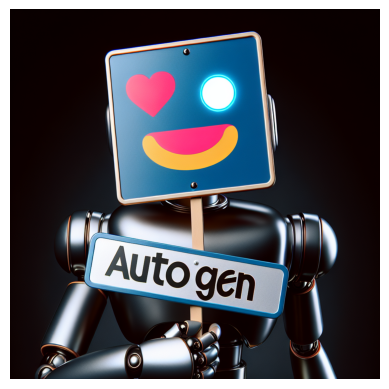

Image PLOTTED
DALLECreator (to Critics):

Here is the prompt: Create an image with black background, a happy robot is showing a sign with "I Love AutoGen"..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLECreator):

CRITICS: The image features a robot holding a sign as requested; however, the visual impact could be enhanced with a brighter and more dynamic color palette on the robot to make it stand out against the black background. The text on the sign could be more integrated into the overall design, and maybe adding a slight glow to the text could help it pop more effectively.

PROMPT: Create an image with a deep black background. The robot should have a sleek, metallic texture with vibrant blue and silver accents to stand out brightly. It smiles j

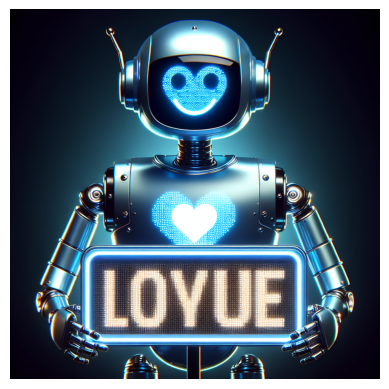

Image 0 PLOTTED
DALLECreator (to Critics):

Here is the prompt: Create an image with a deep black background. The robot should have a sleek, metallic texture with vibrant blue and silver accents to stand out brightly. It smiles joyously, holding a sign with rounded corners that reads "I Love AutoGen" in bold, white, glowing letters. The sign features an LED style, lighting up with an engaging heart icon above the text that also glows softly, adding to the cheerful theme..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLECreator):

CRITICS: The revised image incorporates the metallic texture and glowing elements well. However, there seems to be a typographical error on the sign ("LOYUE" instead of "I Love AutoGen"), which needs correction. Additionally,

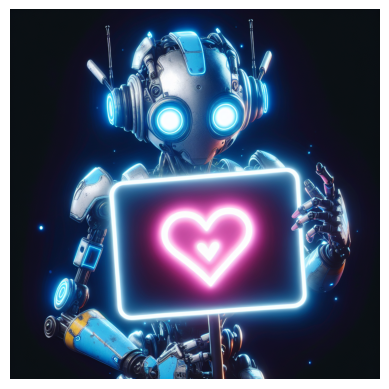

Image 1 PLOTTED
DALLECreator (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with black background, a happy robot is showing a sign with "I Love AutoGen".', 'role': 'assistant', 'name': 'User'}, {'content': 'result.jpg', 'role': 'user', 'name': 'DALLECreator'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [ ]:

user_proxy.initiate_chat(
    creator, message="""Create an image with black background, a happy robot is showing a sign with "I Love AutoGen"."""
)

Ta komenda rozpoczyna zautomatyzowany proces tworzenia i ulepszania obrazu:

1. UserProxy inicjuje rozmowę z DalleCreator
2. Przekazuje prompt opisujący pożądany obraz:
   - czarne tło
   - szczęśliwy robot
   - znak z napisem "I Love AutoGen"

Co się wydarzy:
1. DalleCreator przekaże prompt do agenta DALL-E
2. DALL-E wygeneruje pierwszy obraz
3. Critics przeanalizuje obraz i zaproponuje ulepszenia
4. Proces powtórzy się 2 razy (zgodnie z domyślną wartością n_iters)
5. Na każdym etapie zobaczysz:
   - Wygenerowany obraz
   - Komunikat "Image PLOTTED"
   - Dla kolejnych iteracji: "Image 0 PLOTTED", "Image 1 PLOTTED"

Za każdym razem Critics będzie sugerować zmiany mające na celu poprawę jakości i zgodności obrazu z promptem.